# Introducción

Estas son las bibliotecas y módulos necesarios.

In [6]:
import pandas as pd
import re

import spacy
import nltk
import sklearn
import wordcloud
import matplotlib.pyplot as plt
import pandas as pd

Descargamos los datos necesarios para las actividades

In [7]:
!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen.csv
!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen_corto.csv
!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/proveedoresA.txt
!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/other_vhosts_access.log
nltk.download('stopwords')
nltk.download('wordnet') 
!python -m spacy download es_core_news_sm
import es_core_news_sm
nlp_es = es_core_news_sm.load()

--2021-12-01 01:16:39--  https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29482924 (28M) [text/plain]
Saving to: ‘aysen.csv’

aysen.csv           100%[===================>]  28.12M  --.-KB/s    in 0.1s    

2021-12-01 01:16:39 (188 MB/s) - ‘aysen.csv’ saved [29482924/29482924]

--2021-12-01 01:16:40--  https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen_corto.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4501 (4.4K) [text/plain]
Sa

## Actividad 1: Lectura y parsing

1.   Utilizando la biblioteca Pandas, cargue el archivo `aysen_corto.csv` como un dataframe (revise los tipos de datos, cabecera y separador)
2.   Mantenga solo las columnas `sexo`, `comuna`, y `prestación`.
3.   Realice un conteo de los valores en de las columnas `sexo` y `comuna` y preséntelos en un gráfico.



In [8]:
# HINTS:
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html

# Prográmame

In [9]:
aysen = pd.read_csv("aysen.csv", sep=";", na_values=["Otro",""])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
aysen.head()

,FECHA_NAC,SEXO,PRESTA_MIN,PLANO,EXTREMIDAD,PRESTA_EST,F_ENTRADA,ESTAB_ORIG,ESTAB_DEST,F_SALIDA,C_SALIDA,E_OTOR_AT,PRESTA_MIN_SALIDA,REGION,COMUNA,SOSPECHA_DIAG
0,1985,2,09-001-0,NaN,NaN,ENDODONCIA,31-12-17,25-301,25-100,NaN,NaN,NaN,NaN,11,11101,Celulitis y absceso de boca
1,1946,1,09-004-0,NaN,NaN,PERIODONCIA,31-12-17,25-301,25-100,NaN,NaN,NaN,NaN,11,11101,Periodontitis cronica
2,1937,2,09-006-0,NaN,NaN,REHABILITACION: PROTESIS REMOVIBLE,31-12-17,25-301,25-100,2018-01-03 00:00:00,1.0,25-100,09-006-0,11,11101,Otras afecciones especificadas de los dientes ...
3,1955,2,07-208-0,NaN,NaN,NEUROCIRUGIA,30-12-17,25-300,25-100,NaN,NaN,NaN,NaN,11,11101,"Trastornos de disco lumbar y otros, con radicu..."
4,1997,2,09-001-0,NaN,NaN,ENDODONCIA,30-12-17,25-301,25-100,NaN,NaN,NaN,NaN,11,11101,Celulitis y absceso de boca


In [11]:
aysen_subset = aysen[["SOSPECHA_DIAG","PRESTA_EST"]]

In [12]:
aysen_subset.head()

,SOSPECHA_DIAG,PRESTA_EST
0,Celulitis y absceso de boca,ENDODONCIA
1,Periodontitis cronica,PERIODONCIA
2,Otras afecciones especificadas de los dientes ...,REHABILITACION: PROTESIS REMOVIBLE
3,"Trastornos de disco lumbar y otros, con radicu...",NEUROCIRUGIA
4,Celulitis y absceso de boca,ENDODONCIA


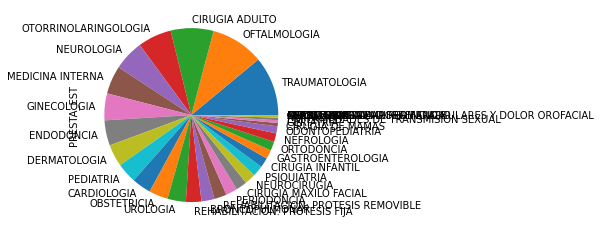

In [13]:
aysen_subset.PRESTA_EST.value_counts(dropna=False).plot.pie()

In [14]:
D10K=pd.DataFrame(aysen_subset.PRESTA_EST.value_counts(dropna=False))
D10K=D10K.loc[D10K["PRESTA_EST"]>10000]
D10K


,PRESTA_EST
TRAUMATOLOGIA,24004
OFTALMOLOGIA,21482
CIRUGIA ADULTO,17321
OTORRINOLARINGOLOGIA,13663
NEUROLOGIA,12316
MEDICINA INTERNA,11408
GINECOLOGIA,10871
ENDODONCIA,10225


In [15]:
list(D10K.index)

['TRAUMATOLOGIA',
 'OFTALMOLOGIA',
 'CIRUGIA ADULTO',
 'OTORRINOLARINGOLOGIA',
 'NEUROLOGIA',
 'MEDICINA INTERNA',
 'GINECOLOGIA',
 'ENDODONCIA']

In [16]:

z1=0
z2=0
presta=[]
sospecha=[]
for u in aysen["PRESTA_EST"]:
  for v in list(D10K.index):
    if u==v:
      #print(u)
      presta.append(u)
      sospecha.append(aysen["SOSPECHA_DIAG"].iloc[z1])
    z2=z2+1 
  z1=z1+1

In [17]:
aysen_nuevo=pd.concat([pd.DataFrame(sospecha).rename(columns={0:"SOSPECHA_DIAG"}),pd.DataFrame(presta).rename(columns={0:"PRESTA_EST"})],axis=1)
aysen_nuevo=aysen_nuevo.reset_index(drop=True)

In [18]:
aysen_nuevo

,SOSPECHA_DIAG,PRESTA_EST
0,Celulitis y absceso de boca,ENDODONCIA
1,Celulitis y absceso de boca,ENDODONCIA
2,FISURA ANAL,CIRUGIA ADULTO
3,Periodontitis apical aguda originada en la pulpa,ENDODONCIA
4,"Osteomielitis, no especificada",TRAUMATOLOGIA
...,...,...
121285,HIPERTENSION ESENCIAL (PRIMARIA),MEDICINA INTERNA
121286,Consulta no Especificada,MEDICINA INTERNA
121287,HERNIAS DEL NUCLEO PULPOSO,NEUROLOGIA
121288,Consulta no Especificada,CIRUGIA ADULTO


In [19]:
# Corrígeme
# pattern = r"""(?x)                   # set flag to allow verbose regexps
#               (?:[A-Z]\.)+           # abbreviations, e.g. U.S.A.
#               |\d+(?:\.\d+)?%?       # numbers, incl. currency and percentages
#               |\w+(?:[-']\w+)*       # words w/ optional internal hyphens/apostrophe
#               |(?:[+/\-@&*])         # special characters with meanings
#             """

pattern = r"""(?x)                   # set flag to allow verbose regexps
              (?:[A-Z]\.)+           # abbreviations, e.g. U.S.A.
              |\$?\d+(?:[.,]\d+)?%?  # numbers, incl. currency and percentages
              |\w+(?:[-']\w+)*       # words w/ optional internal hyphens/apostrophe
              |(?:[+/\-@&*¡!.,])     # special characters with meanings
            """

def cambiate(text):
  hola=nltk.regexp_tokenize(text, pattern)
  separator = ' '
  hola2=separator.join(hola)
  return hola2


In [20]:
cambiate(aysen_nuevo["SOSPECHA_DIAG"].iloc[121285])

'HIPERTENSION ESENCIAL PRIMARIA'

In [21]:
aysen_nuevo['SOSPECHA_DIAG_NUEVO'] = aysen_nuevo.apply(lambda x: cambiate(x.SOSPECHA_DIAG), axis=1)

In [22]:
aysen_nuevo

,SOSPECHA_DIAG,PRESTA_EST,SOSPECHA_DIAG_NUEVO
0,Celulitis y absceso de boca,ENDODONCIA,Celulitis y absceso de boca
1,Celulitis y absceso de boca,ENDODONCIA,Celulitis y absceso de boca
2,FISURA ANAL,CIRUGIA ADULTO,FISURA ANAL
3,Periodontitis apical aguda originada en la pulpa,ENDODONCIA,Periodontitis apical aguda originada en la pulpa
4,"Osteomielitis, no especificada",TRAUMATOLOGIA,"Osteomielitis , no especificada"
...,...,...,...
121285,HIPERTENSION ESENCIAL (PRIMARIA),MEDICINA INTERNA,HIPERTENSION ESENCIAL PRIMARIA
121286,Consulta no Especificada,MEDICINA INTERNA,Consulta no Especificada
121287,HERNIAS DEL NUCLEO PULPOSO,NEUROLOGIA,HERNIAS DEL NUCLEO PULPOSO
121288,Consulta no Especificada,CIRUGIA ADULTO,Consulta no Especificada


In [23]:
nltk_stopwords = nltk.corpus.stopwords.words('spanish')
spacy_stopwords = spacy.lang.es.stop_words.STOP_WORDS

stop_words_union = set(list(nltk_stopwords) + list(spacy_stopwords))
stop_words_final = []
for word in stop_words_union:
  if word not in spacy_stopwords:
    stop_words_final.append(word)
  if word not in nltk_stopwords:
    stop_words_final.append(word)


def cambiate2(text):
  hola=nltk.regexp_tokenize(text, pattern)
  nuevohola=[]
  for word in hola:
    if word not in stop_words_final:
      nuevohola.append(word)
  separator = ' '
  hola2=separator.join(nuevohola)
  return hola2

In [24]:
aysen_nuevo["SOSPECHA_DIAG"].iloc[121285]="HIPERTENSION ESENCIAL PRIMARIA cerca"

In [25]:
print(aysen_nuevo["SOSPECHA_DIAG"].iloc[121285])

HIPERTENSION ESENCIAL PRIMARIA cerca


In [26]:
print(cambiate2(aysen_nuevo["SOSPECHA_DIAG"].iloc[121285]))

HIPERTENSION ESENCIAL PRIMARIA


In [27]:
aysen_nuevo['SOSPECHA_DIAG_NUEVO'] = aysen_nuevo.apply(lambda x: cambiate2(x.SOSPECHA_DIAG_NUEVO), axis=1)

In [28]:
aysen_nuevo

,SOSPECHA_DIAG,PRESTA_EST,SOSPECHA_DIAG_NUEVO
0,Celulitis y absceso de boca,ENDODONCIA,Celulitis absceso de boca
1,Celulitis y absceso de boca,ENDODONCIA,Celulitis absceso de boca
2,FISURA ANAL,CIRUGIA ADULTO,FISURA ANAL
3,Periodontitis apical aguda originada en la pulpa,ENDODONCIA,Periodontitis apical aguda originada en la pulpa
4,"Osteomielitis, no especificada",TRAUMATOLOGIA,"Osteomielitis , no especificada"
...,...,...,...
121285,HIPERTENSION ESENCIAL PRIMARIA cerca,MEDICINA INTERNA,HIPERTENSION ESENCIAL PRIMARIA
121286,Consulta no Especificada,MEDICINA INTERNA,Consulta no Especificada
121287,HERNIAS DEL NUCLEO PULPOSO,NEUROLOGIA,HERNIAS DEL NUCLEO PULPOSO
121288,Consulta no Especificada,CIRUGIA ADULTO,Consulta no Especificada


In [29]:
stemmer = nltk.stem.SnowballStemmer("spanish")
#lemmatizer = nltk.stem.WordNetLemmatizer() no hay en español

def cambiate3(text):
  hola=nltk.regexp_tokenize(text, pattern)
  nuevohola=[]
  for word in hola:
    nuevohola.append(stemmer.stem(word))
  separator = ' '
  hola2=separator.join(hola)
  return hola2

In [30]:
stemmer.stem("Especificada")

'especific'



# Análisis no-supervisado y visualización (2 pts)



* Utilice en esta sección la salida de la sección de limpieza, o el texto crudo.

* Visualice utilizando wordcloud las palabras más comunes para cada
categoría D10K.

In [35]:
list(D10K.index)

['TRAUMATOLOGIA',
 'OFTALMOLOGIA',
 'CIRUGIA ADULTO',
 'OTORRINOLARINGOLOGIA',
 'NEUROLOGIA',
 'MEDICINA INTERNA',
 'GINECOLOGIA',
 'ENDODONCIA']

In [36]:
D10K.describe

<bound method NDFrame.describe of                       PRESTA_EST
TRAUMATOLOGIA              24004
OFTALMOLOGIA               21482
CIRUGIA ADULTO             17321
OTORRINOLARINGOLOGIA       13663
NEUROLOGIA                 12316
MEDICINA INTERNA           11408
GINECOLOGIA                10871
ENDODONCIA                 10225>

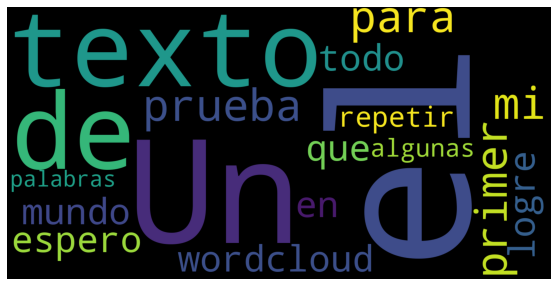

In [5]:
description = "Un texto de prueba para mi primer wordcloud en el todo el mundo, espero que logre repetir algunas palabras"
wc = wordcloud.WordCloud(width=1600, height=800).generate(description)
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [37]:
tfidf_vectorizer_aysen = sklearn.feature_extraction.text.TfidfVectorizer(stop_words="english",max_df=0.20)
x_aysen = tfidf_vectorizer_aysen.fit_transform(aysen.SOSPECHA_DIAG)

In [42]:
def plot_wordcloud_from_specialty(specialty):
  tfidf_dict = dict(zip(tfidf_vectorizer_aysen.get_feature_names_out(),x_aysen.toarray()[aysen.PRESTA_EST == specialty].mean(0).reshape(-1,)))
  tfidf_dict = {word:val for word,val in tfidf_dict.items() if val > 0}
  wc = wordcloud.WordCloud(width=1600, height=800).generate_from_frequencies(tfidf_dict)
  plt.figure(figsize=(10,5))
  plt.imshow(wc)
  plt.axis("off")
  plt.show()

TRAUMATOLOGIA


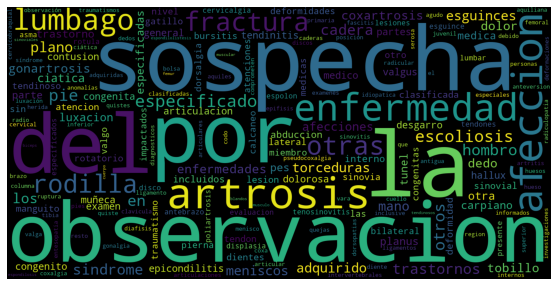

OFTALMOLOGIA


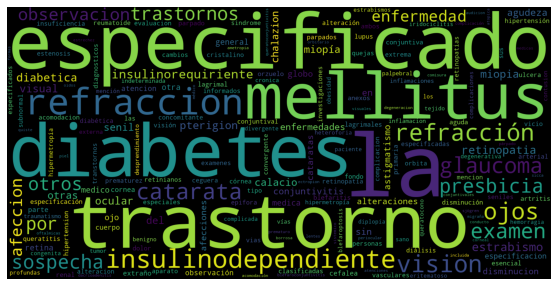

CIRUGIA ADULTO


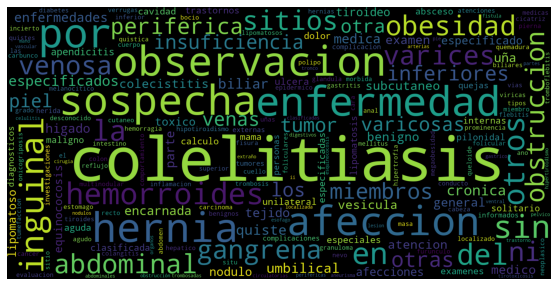

OTORRINOLARINGOLOGIA


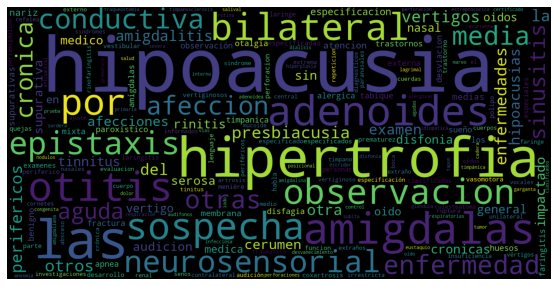

NEUROLOGIA


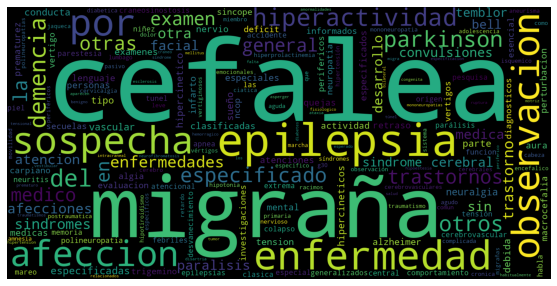

MEDICINA INTERNA


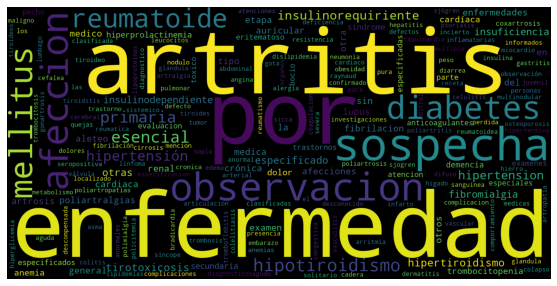

GINECOLOGIA


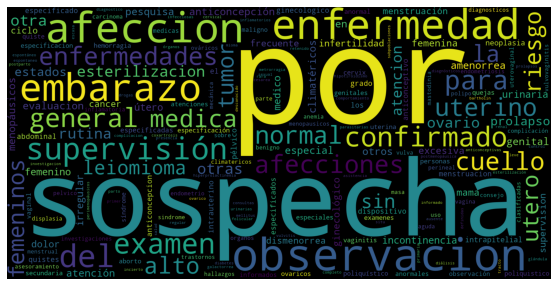

ENDODONCIA


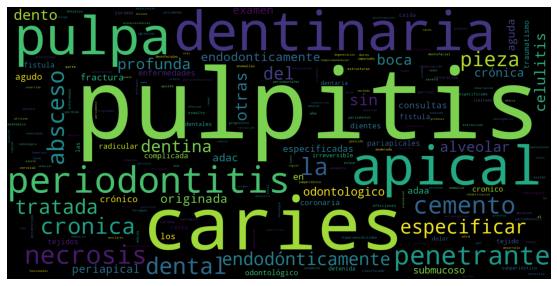

In [43]:
for specialty in list(D10K.index):
  print(f"{specialty}")
  plot_wordcloud_from_specialty(specialty)